<a href="https://colab.research.google.com/github/ZachPetroff/Using-Autoencoder-For-Dimensionality-Reduction-to-Obtain-Higher-Accuracy-in-Pytorch/blob/main/DeepLearningMiniProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project Approach

**Supervised Method:** *Artificial Neural Network*

**Unsupervised Method:** *Autoencoder*

> For this mini-project, I will first perform dimensionality reduction using an autoencoder, then use the transformed data paired with a regular feed forward network
to classify data.

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [ ]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Data Preprocessing Steps

*   Check for missing values
*   Normalize Ages, Balances, Durations, Campaign, Previous
*   One Hot Encode Jobs, Marital, Education, Contact, Month, Poutcome
*   Discretize Default, Housing, Loan, Y
*   Delete Day because it seems unimportant, and pdays because the data entry seems to be unsalvagably incorrect and the data description offers no explanation.



In [ ]:
# drop day and pdays
df = df.drop(['day', 'pdays'], axis=1)

In [ ]:
# check for missing values
cols = df.columns

for col in cols:
  print("Number of missing values in ", col, " column: ", sum(df[col].isnull()))

# No missing values!

Number of missing values in  age  column:  0
Number of missing values in  job  column:  0
Number of missing values in  marital  column:  0
Number of missing values in  education  column:  0
Number of missing values in  default  column:  0
Number of missing values in  balance  column:  0
Number of missing values in  housing  column:  0
Number of missing values in  loan  column:  0
Number of missing values in  contact  column:  0
Number of missing values in  month  column:  0
Number of missing values in  duration  column:  0
Number of missing values in  campaign  column:  0
Number of missing values in  previous  column:  0
Number of missing values in  poutcome  column:  0
Number of missing values in  y  column:  0


In [ ]:
# One hot encode categorical values

job = pd.get_dummies(df.job, prefix='job')
marital = pd.get_dummies(df.marital, prefix='marital')
education = pd.get_dummies(df.education, prefix='education')
contact = pd.get_dummies(df.contact, prefix='contact')
month = pd.get_dummies(df.month, prefix='month')
poutcome = pd.get_dummies(df.poutcome, prefix='poutcome')

In [ ]:
# Add one hot encoded categorical values & drop original columns
df = df.drop(['job', 'marital', 'education', 'contact', 'month', 'poutcome'], axis=1)

# add one hot encoded values
df = pd.concat([df, job], axis=1)
df = pd.concat([df, marital], axis=1)
df = pd.concat([df, education], axis=1)
df = pd.concat([df, contact], axis=1)
df = pd.concat([df, month], axis=1)
df = pd.concat([df, poutcome], axis=1)

df.head()

,age,default,balance,housing,loan,duration,campaign,previous,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,no,2143,yes,no,261,1,0,no,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,44,no,29,yes,no,151,1,0,no,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,33,no,2,yes,yes,76,1,0,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,47,no,1506,yes,no,92,1,0,no,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,33,no,1,no,no,198,1,0,no,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
# discretize values (pretty much the same process as one hot encoding, expcept we only have to add one column)

default = pd.get_dummies(df.default, prefix='default')
housing = pd.get_dummies(df.housing, prefix='housing')
loan = pd.get_dummies(df.loan, prefix='loan')
y = pd.get_dummies(df.y, prefix='y')

In [ ]:
# Add discretized values & drop original columns
df = df.drop(['default', 'housing', 'loan', 'y'], axis=1)

# add discretized values
df = pd.concat([df, default['default_no']], axis=1)
df = pd.concat([df, housing['housing_yes']], axis=1)
df = pd.concat([df, loan['loan_no']], axis=1)
df = pd.concat([df, y['y_yes']], axis=1)

df.head()

,age,balance,duration,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default_no,housing_yes,loan_no,y_yes
0,58,2143,261,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0
1,44,29,151,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0
2,33,2,76,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0
3,47,1506,92,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0
4,33,1,198,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0


In [ ]:
# Normalize numeric values
num_vals = ['age', 'balance', 'duration', 'campaign', 'previous']

for col in num_vals:
  df[col] = (df[col] - df[col].mean())/df[col].std()

In [ ]:
df.head()

,age,balance,duration,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,default_no,housing_yes,loan_no,y_yes
0,1.606947,0.256416,0.011016,-0.569344,-0.251938,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0
1,0.288526,-0.437890,-0.416122,-0.569344,-0.251938,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0
2,-0.747376,-0.446758,-0.707353,-0.569344,-0.251938,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0
3,0.571045,0.047205,-0.645224,-0.569344,-0.251938,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0
4,-0.747376,-0.447086,-0.233618,-0.569344,-0.251938,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0


In [ ]:
# split up data and y
y = df['y_yes']
df = df.drop(['y_yes'], axis=1)

# Build and Train Autoencoder

> Once the autoencoder is trained, we can get our dimensionally reduced data by getting activations in the middle of the autoencoder for each piece of data.

In [ ]:
data_np = np.array(df)
training_set = torch.FloatTensor(data_np)

In [ ]:
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        # basic feed forward NN architecture
        # except we are constricting then re-expanding the data
        self.fc1 = nn.Linear(46, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 2)
        self.fc5 = nn.Linear(2, 8)
        self.fc6 = nn.Linear(8, 16)
        self.fc7 = nn.Linear(16, 32)
        self.fc8 = nn.Linear(32, 46)
        # im using sigmoid, because with relu the activations kept going to zero
        # which negatively affected the dim reduced data
        self.activation = nn.Tanh()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.activation(self.fc5(x))
        x = self.activation(self.fc6(x))
        x = self.activation(self.fc7(x))
        x = self.fc8(x)
        return x
sae = SAE()
# loss fxn
criterion = nn.MSELoss()
# hyperparameters
optimizer = optim.Adam(sae.parameters(), lr = 1e-6, weight_decay = 0.5)

In [ ]:
# train for 20 epochs
nb_epoch = 15
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0.
  for index in range(len(training_set)):
    # get input
    input = Variable(training_set[index]).unsqueeze(0)
    # expected output is the same as input, so we clone input
    target = input.clone()
    # get output from nn
    output = sae(input)
    # target will not be changed
    target.require_grad = False
    # get loss (difference between output and original input)
    loss = criterion(output, target)
    # propagate loss backward in the netword
    loss.backward()
    # update train loss
    train_loss += np.sqrt(loss.data)
    s += 1.
    optimizer.step()
  print('epoch: '+str(epoch)+'loss: '+ str(train_loss/s))

epoch: 1loss: tensor(0.4699)
epoch: 2loss: tensor(0.4233)
epoch: 3loss: tensor(0.4167)
epoch: 4loss: tensor(0.4065)
epoch: 5loss: tensor(0.4064)
epoch: 6loss: tensor(0.4162)
epoch: 7loss: tensor(0.4014)
epoch: 8loss: tensor(0.3973)
epoch: 9loss: tensor(0.3955)
epoch: 10loss: tensor(0.3937)
epoch: 11loss: tensor(0.3956)
epoch: 12loss: tensor(0.4008)
epoch: 13loss: tensor(0.4076)
epoch: 14loss: tensor(0.3934)
epoch: 15loss: tensor(0.3924)


# Get All Dimension Reduced Data And Visualize
> We get the dimension reduced data by passing the data through the first four layers of the network and taking the activations. We then remove these values from the tensor so they can be stored in a list and eventually a numpy array. 

> Because our new data is two dimensional, we are able to visualize it. We can see that there does seem to be some separation between the two classes, though, not much. This problem would likely be too complicated for anything other than a neural network, which is able to do many different types of data transformations before classifying. 

In [ ]:
# get data with reduced dimensions using autoencoder
dim_red = []
for i in range(len(training_set)):
  x = sae.activation(sae.fc1(Variable(training_set[i]).unsqueeze(0)))
  x = sae.activation(sae.fc2(x))
  x = sae.activation(sae.fc3(x))
  x = sae.activation(sae.fc4(x))
  x = [x[0][0].item(), x[0][1].item()]
  dim_red.append(x)

[[-0.23919177055358887, 0.3220425248146057], [-0.45856359601020813, 0.21327708661556244], [-0.3540443480014801, 0.1922466903924942], [-0.03658036142587662, 0.20805367827415466], [-0.38825637102127075, 0.17985562980175018], [-0.27592986822128296, 0.20801083743572235], [-0.4805655777454376, 0.17111225426197052], [-0.32135578989982605, 0.193911612033844], [-0.04418512061238289, 0.5347551107406616], [-0.466854989528656, 0.2196432203054428], [-0.3937416076660156, 0.1948591023683548], [-0.4660406708717346, 0.19159702956676483], [-0.3076966404914856, 0.19818225502967834], [-0.112099789083004, 0.32950741052627563], [-0.1546546071767807, 0.28143739700317383], [-0.046919964253902435, 0.27286496758461], [-0.5294952988624573, 0.2523573935031891], [-0.13862891495227814, 0.4355306327342987], [-0.061365414410829544, 0.48869335651397705], [-0.31620171666145325, 0.18623556196689606], [-0.3305192291736603, 0.16661538183689117], [-0.32712599635124207, 0.34349894523620605], [-0.4864312708377838, 0.1993475

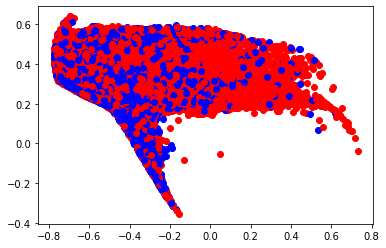

In [ ]:
import matplotlib.pyplot as plt
import random

# plot dim reduced data, colored by class
for i in range(len(y)):
  if y.iloc[i] == 0:
    plt.plot(dim_red[i][0], dim_red[i][1], "ro")
  if y.iloc[i] == 1:
    plt.plot(dim_red[i][0], dim_red[i][1], "bo")

plt.show()

# Split Up Training and Testing Data 
> Test data will make up 15% of the overall data. This will be used to test how well the neural network performs and if we get a better score by using dimensionally reduced data.



In [ ]:
train_data = []
test_data = []
train_y = []
test_y = []

for entry in range(len(dim_red)):
  if random.random() < .15:
    test_data.append(dim_red[entry])
    test_y.append(y.iloc[i])
  else:
    train_data.append(dim_red[entry])
    train_y.append(y.iloc[i])

# Building The ANN

> I created a very basic neural network, with five layers, each layer having 10 nodes. The activation function I used was ReLU, which is pretty much the default for neural networks. The output goes through the sigmoid activation function because it is a binary classification problem. I used MSELoss, because I had problems with BCELoss. The learning rate was set to 1e-6, which seemed to be a pretty good choice. It was originally higher, but the network had a hard time converging.

In [ ]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # basic feed forward NN architecture
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 10)
        self.fc4 = nn.Linear(10, 10)
        self.fc5 = nn.Linear(10, 1)
        self.activation = nn.ReLU()
        self.output = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.output(self.fc5(x))
        return x
ann = Net()
# loss fxn
crit = nn.MSELoss()
# hyperparameters
opt = optim.Adam(ann.parameters(), lr = 1e-6)

# Convert Data to Torch Tensors and Train Network
> The number of epochs I chose was 50. Originally, it was 20, then 30, but the network wasn't fully converging. I was able to get a loss of around .12

In [ ]:
dim_train_np = np.array(train_data)
training_set = torch.FloatTensor(dim_train_np)

dim_test_np = np.array(test_data)
test_set = torch.FloatTensor(dim_test_np)

train_targ = np.array(train_y)
test_targ = np.array(test_y)

In [ ]:
from torch.autograd._functions import Resize

In [ ]:
# train for 30 epochs
nb_epoch = 50
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0.
  for index in range(len(training_set)):
    opt.zero_grad()
    
    # get input
    input = Variable(training_set[index]).unsqueeze(0)

    # expected output is the same as input, so we clone input
    target = torch.zeros(1) + target_np[index]
    
    # get output from nn
    output = ann(input)

    # target will not be changed
    target.require_grad = False
    
    # get loss (difference between output and original input)
    target = Resize.apply(target, (1, 1))
    loss = crit(output, target)
    
    # propagate loss backward in the network
    loss.backward()
    
    # update train loss
    train_loss += np.sqrt(loss.data)
    s += 1.
    opt.step()
  print('epoch: '+str(epoch)+' loss: '+ str(train_loss/s))

epoch: 1 loss: tensor(0.4294)
epoch: 2 loss: tensor(0.4041)
epoch: 3 loss: tensor(0.3768)
epoch: 4 loss: tensor(0.3487)
epoch: 5 loss: tensor(0.3197)
epoch: 6 loss: tensor(0.2871)
epoch: 7 loss: tensor(0.2538)
epoch: 8 loss: tensor(0.2232)
epoch: 9 loss: tensor(0.1977)
epoch: 10 loss: tensor(0.1779)
epoch: 11 loss: tensor(0.1632)
epoch: 12 loss: tensor(0.1523)
epoch: 13 loss: tensor(0.1443)
epoch: 14 loss: tensor(0.1385)
epoch: 15 loss: tensor(0.1341)
epoch: 16 loss: tensor(0.1308)
epoch: 17 loss: tensor(0.1284)
epoch: 18 loss: tensor(0.1265)
epoch: 19 loss: tensor(0.1250)
epoch: 20 loss: tensor(0.1239)
epoch: 21 loss: tensor(0.1231)
epoch: 22 loss: tensor(0.1224)
epoch: 23 loss: tensor(0.1219)
epoch: 24 loss: tensor(0.1215)
epoch: 25 loss: tensor(0.1212)
epoch: 26 loss: tensor(0.1209)
epoch: 27 loss: tensor(0.1207)
epoch: 28 loss: tensor(0.1206)
epoch: 29 loss: tensor(0.1205)
epoch: 30 loss: tensor(0.1204)
epoch: 31 loss: tensor(0.1203)
epoch: 32 loss: tensor(0.1202)
epoch: 33 loss: t

# Test The Network
> I was able to correctly classify 100% of the test data!

In [ ]:
def score(data, targ):
  acc = 0
  for i in range(len(data)):
    with torch.no_grad():
      input = Variable(data[i]).unsqueeze(0)
      target = targ[i]
    
      # get output from nn
      output = ann(input)
      output = output.item()
      
      if target == round(output):
        acc += 1

  return(acc/len(data))

print(score(test_set, test_targ))

1.0


# Training ANN On The Original Data to See How It Differs From Dim Reduced Data
> Here, I used a smaller but wider network, with around the same number of parameters. I used a wider network so there would not be an information bottleneck. Everything else was kept the same. 

In [ ]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # basic feed forward NN architecture
        self.fc1 = nn.Linear(46, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 1)
        self.activation = nn.ReLU()
        self.output = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.output(self.fc4(x))
        return x
        
ann = Net()
# loss fxn
crit = nn.MSELoss()
# hyperparameters
opt = optim.Adam(ann.parameters(), lr = 1e-6)

In [ ]:
big_train_data = []
big_train_y = []
big_test_data = []
big_test_y = []

for i in range(len(data_np)):
  if random.random() < .15:
    big_test_data.append(data_np[i])
    big_test_y.append(y.iloc[i])
  else:
    big_train_data.append(data_np[i])
    big_train_y.append(y.iloc[i])

big_training_set = torch.FloatTensor(big_train_data)
big_testing_set = torch.FloatTensor(big_test_data)
big_targ_np = np.array(big_train_y)

In [ ]:
# train for 30 epochs
nb_epoch = 50
for epoch in range(1, nb_epoch + 1):
  train_loss = 0
  s = 0.
  for index in range(len(big_training_set)):
    opt.zero_grad()
    
    # get input
    input = Variable(big_training_set[index]).unsqueeze(0)

    # expected output is the same as input, so we clone input
    target = torch.zeros(1) + big_targ_np[index]
    
    # get output from nn
    output = ann(input)

    # target will not be changed
    target.require_grad = False
    
    # get loss (difference between output and original input)
    target = Resize.apply(target, (1, 1))
    loss = crit(output, target)
    
    # propagate loss backward in the network
    loss.backward()
    
    # update train loss
    train_loss += np.sqrt(loss.data)
    s += 1.
    opt.step()
  print('epoch: '+str(epoch)+' loss: '+ str(train_loss/s))

epoch: 1 loss: tensor(0.4980)
epoch: 2 loss: tensor(0.3733)
epoch: 3 loss: tensor(0.2311)
epoch: 4 loss: tensor(0.1899)
epoch: 5 loss: tensor(0.1809)
epoch: 6 loss: tensor(0.1775)
epoch: 7 loss: tensor(0.1751)
epoch: 8 loss: tensor(0.1725)
epoch: 9 loss: tensor(0.1697)
epoch: 10 loss: tensor(0.1669)
epoch: 11 loss: tensor(0.1640)
epoch: 12 loss: tensor(0.1611)
epoch: 13 loss: tensor(0.1584)
epoch: 14 loss: tensor(0.1561)
epoch: 15 loss: tensor(0.1541)
epoch: 16 loss: tensor(0.1524)
epoch: 17 loss: tensor(0.1508)
epoch: 18 loss: tensor(0.1494)
epoch: 19 loss: tensor(0.1482)
epoch: 20 loss: tensor(0.1471)
epoch: 21 loss: tensor(0.1462)
epoch: 22 loss: tensor(0.1454)
epoch: 23 loss: tensor(0.1446)
epoch: 24 loss: tensor(0.1440)
epoch: 25 loss: tensor(0.1434)
epoch: 26 loss: tensor(0.1428)
epoch: 27 loss: tensor(0.1423)
epoch: 28 loss: tensor(0.1419)
epoch: 29 loss: tensor(0.1415)
epoch: 30 loss: tensor(0.1411)
epoch: 31 loss: tensor(0.1407)
epoch: 32 loss: tensor(0.1404)
epoch: 33 loss: t

# Original Data Results
> The unchanged data was able to classify around 90% of the data correctly. This is good, however we were able to get a test score of about 10% higher with the dimension reduced data! This is huge in terms of test accuracy, reducing the dimensions of the data definitely seems to be worth it.

In [ ]:
print(score(big_testing_set, np.array(big_test_y)))

0.8954112038140644


In [ ]:
import numpy as np

def flip_array(array):
    new_array = np.zeros((len(array), len(array[0])))
    for i in range(len(array)):
        nj = 0
        for j in range(len(array[0])-1, -1, -1):
            new_array[i][nj] = array[i][j]
            nj += 1
    return list(new_array)

arr = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
print(flip_array(arr))

def split_by_col(array, col):
    new_array = np.zeros((len(array), col))
    for i in range(len(array)):
        for j in range(col):
            new_array[i][j] = array[i][j]
    new_array2 = np.zeros((len(array), 3-col))
    for i in range(len(array)):
        for j in range(3-col):
            new_array2[i][j] = array[i][2-j]
    return new_array, new_array2

print(split_by_col(arr, 2)[0], '\n', split_by_col(arr, 2)[1])

[array([3., 2., 1.]), array([6., 5., 4.]), array([9., 8., 7.])]
[[1. 2.]
 [4. 5.]
 [7. 8.]] 
 [[3.]
 [6.]
 [9.]]
